# Experiments with the MUSIC Algorithm

Updated March 28th, 2023

In [67]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from tqdm import tqdm

## Support Functions

In [68]:
#enabling random configurations

def generate_random_frequencies(freq_range,min_freq_diff,D_signals):
    """Randomly select D different frequencies with a minimum difference and within a given frequency range

    Args:
        freq_range (np.array): [min frequency, max frequency]
        min_freq_diff (float): the minimum separation between frequencies
        D_signals (int): the number of signals

    Returns:
        np.array: A list with D_signals different signal frequencies
    """
    
    #come up with an array of options
    a = np.arange(freq_range[0],freq_range[1],min_freq_diff)

    #randomly select from the list
    return np.random.choice(a,size=D_signals,replace=False)

def generate_random_angles(AoA_range,min_angular_diff,D_signals):
    """Randomly select D different angles of arrival with a minimum difference and within a given range

    Args:
        AoA_range (np.array): [min frequency, max frequency]
        min_angular_diff (float): the minimum separation between angles
        D_signals (int): the number of signals

    Returns:
        np.array: A list with D_signals different angles for each signal
    """
    
    #come up with an array of options
    a = np.arange(AoA_range[0],AoA_range[1],min_angular_diff)

    #randomly select from the list
    return np.random.choice(a,size=D_signals,replace=False)

# generating example signals and noise values
def generate_sample_signal(f,t,complex=True,plot = False):
    """Generates a sinusoidal signal to be used for testing the MUSIC algorithm
    Args:
        f (float): the desired frequency (in Hz) of the sinusoid
        t (np.array): the sample times at which to generate the sinusoid
        complex (bool, optional): generates a complex sinusoid on True. Defaults to True.
        plot (bool, optional): plots the generated signal on True. Defaults to False.
    """
    #generate the signal
    if complex:
        x = np.exp(2j * np.pi * f * t)
    else:
        x =  np.sin(2 * np.pi * f * t)

    #plot the signal
    if plot:
        plot_signal(x,t)
    
    #return the generated signal
    return x
    
def generate_signals(freqs,t,complex=True,verbose=False):
    """Generates a series of sample signals to be used to test the MUSIC algorithm

    Args:
        freqs (np.array): array of the frequencies (in Hz) of the sample sinusoids
        t (np.array): the sample times at which to generate the sinusoid
        complex (bool, optional): generate complex sinusoids on True. Defaults to True.
        verbose (bool, optional): Print out the final s(t) signal matrix on True. Defaults to False.

    Returns:
        np.array: len(freqs) x len(t) array of sample sinusoidal signals
    """
    
    #initialize the s_t array
    if complex:
        s_t = np.empty((len(freqs),len(t)),dtype=np.complex_)
    else:
        s_t = np.empty((len(freqs),len(t)),dtype=float)
    
    #generate the signals
    for i in range(0,len(freqs)):
        s_t[i,:] = generate_sample_signal(freqs[i],t,complex=complex)
    
    #print the generated signals if verbose is true
    if verbose:
        out_str = "s(t) = \n{}".format(s_t)
        print(out_str)
    
    return s_t

def plot_signal(x,t,title = "Sine Wave"):
    """generates a plot of the sample signal

    Args:
        x (np.array): x(t) values
        t (np.array): time samples
        title (str, optional): Plot title. Defaults to "Sine Wave".
    """
    #plotting for if the signal is complex
    if np.iscomplex(x).any():
        plt.plot(t, x.real)
        plt.plot(t, x.imag)
        plt.legend(['Real', 'Imaginary'])
    else:
        plt.plot(t,x)
        plt.legend(['Signal'])
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title(title)
    plt.show()

def compute_signal_power(x,dB = False):
    """Compute the power of a given signal (used to verify that SNR is correct)

    Args:
        x (np.array): the signal to compute the power of
        dB (bool, optional): on True converts the power to dB. Defaults to False
    """
    N = len(x)
    pow = np.power(np.linalg.norm(x[0,:]),2) * 1/N

    if dB:
        return 10 * np.log10(pow)
    else:
        return pow

def determine_signal_amplitude(snr,sigma_2 = 1):
    """Compute the required amplitude for a complex sinusoidal signal in noise for a given SNR

    Args:
        snr (_type_): _description_
        sigma_2 (float,optional): the noise variance. Defaults to 1
    Returns:
        (float,float): tuple with (Signal power, signal amplitude)
    """

    P_s_t = sigma_2 * (10 ** (snr/10))

    Amp_s_t = np.sqrt(P_s_t) #not multiplying by 2 because this is a complex sinusoidal signal

    return P_s_t,Amp_s_t

def generate_noise_samples(sigma_2, cross_corr, K_Rx, N_samples,verbose = False):
    """Generate n_t (the noise samples) with a given signal variance and potential cross-correlation between different antenna elements

    Args:
        sigma_2 (float): The noise variance for each element
        cross_corr (float): The correlation between each element and the other elements
        K_Rx (int): The number of receive elements
        N_samples (int): The number of noise samples to generate
        verbose(bool, optional): prints the noise covariance matrix on True, Defaults to False.
    """
    
    #assume noise has a mean of zero
    mu = np.zeros((K_Rx))

    #set the cross correlation terms of the noise covariance matrix
    cov = np.ones((K_Rx,K_Rx)) * cross_corr / 2 #also dividing by 2 because it is composed of complex samples
    np.fill_diagonal(cov,sigma_2/2) #divigin sigma squared by 2 because it is composed of complex samples
    
    #generate the noise samples (have to generate real and complex separately as np can't generate complex on its own)
    noise_samples = np.random.multivariate_normal(mu,cov,size=(2,N_samples)).transpose()

    #combine real and complex into final noise sample set
    n_t = noise_samples[:,:,0] + 1j * noise_samples[:,:,1]

    if verbose:
        out_str = "Set Noise Covariance Matrix:\n{}".format(cov * 2)
        print(out_str)

        cov_estimated = np.abs(np.cov(n_t))
        out_str = "\n\n\nActual Noise Coveriance Matrix:\n{}".format(cov_estimated)
        print(out_str)

    return n_t

#MUSIC Specific Functions

def compute_mode_vector(theta,K_Rx,radians=False,verbose = False):
    """Computes a mode vector for a given value of theta

    Args:
        theta (float): AoA for the given mode vecotor [in degrees (assumed) or radians]
        K_Rx (int): The number of receivers
        radians (bool, optional): Assumes theta is in radians if true. Defaults to False.
        verbose (bool, optional): prints the return matrix. Defaults to False.

    Returns:
        np.array: K_Rx x 1 mode vector for the corresponding theta
    """
    #define the k indicies
    k = np.arange(1,K_Rx + 1)

    #convert to radians if theta is given in degrees
    if not radians:
        theta = np.deg2rad(theta)
    
    #compute the mode vector
    a_theta = np.array([np.exp(1j * np.pi * (k - 1) * np.sin(theta))]).transpose()

    if verbose:
        ret_string = "A(theta) = \n{}".format(a_theta)
        print(ret_string)
    
    return a_theta

def generate_mode_vector_matrix(thetas,K_rx,radians=False,verbose = False):
    """Generate the A matrix (each column is a mode vector corresponding to a specific theta)

    Args:
        thetas (np.array):list of AoA angles [in degrees (assumed) or radians] for each signal
        K_rx (int): Number of receivers
        radians (bool, optional): Assumes theta is in radians if true. Defaults to False.
        verbose (bool, optional): prints the return matrix. Defaults to False.

    Returns:
        _type_: _description_
    """

    #initialize empty A matrix
    A = np.empty((K_rx,len(thetas)),dtype=np.complex_)

    #compute each mode vector for a given theta
    for i in range(0,len(thetas)):
        A[:,i:i+1] = compute_mode_vector(theta=thetas[i],K_Rx=K_rx,radians=radians,verbose=False)
    
    #print resulting A matrix if verbose set to true
    if verbose:
        out_str = "A Matrix: \n{}".format(A)
        print(out_str)
    
    return A

def compute_P_MU(theta,E_N,K_rx,radians=False):
    """Compute P_mu from the MUSIC algorithm

    Args:
        theta (float): angle to use when generating the mode vector [in degrees (assumed) or radians]
        E_N (np.array): K_rx x D_signals matrix whose columns are the eigen vectors in the nullspace of the mode vector matrix
        K_rx (int): number of receivers
        radians (bool, optional): Assumes theta is in radians if true. Defaults to False.

    Returns:
        P_MU(theta): the music spectrum for the given angle of arrival
    """
    
    #compute mode vector
    a_theta = compute_mode_vector(theta,K_rx,radians)

    return 1 / (a_theta.conj().transpose() @ E_N @ E_N.conj().transpose() @ a_theta)

def MUSIC(x_t,K_rx, D_signals,log_scale = True, plot_spectrum = True,verbose = False, transparent_mode=False, s_t = None,A=None):
    """ Performs the MUSIC algorithm (optional tranparent mode to see what is going on under the hood)

    Args:
        x_t (np.array): K_rx -by- (number of samples) samples for each receiver (sensor)
        K_rx (int): number of receivers
        s_t (np.array,optional): D_signals -by- (number of samples) samples for each of the D signals. Defaults to None
        A (np.array,optional): K_rx -by- D_signals matrix containing the true mode vectors. Defaults to None
        D_signals (int): The number of signals for the MUSIC algorithm to assume (algorithm currently doesn't compute this)
        log_scale (bool, optional): Plots and returns P_mus in log scale on True. Defaults to True
        plot_spectrum (bool, optional): plots the MUSIC spectrum when true. Defaults to True.
        verbose (bool, optional): Reports back all major calculations when True. Defaults to False.
        transparent_mode(bool,optional): In transparent mode, the algorithm also computes Rs and A Rs A^H so that the user
            can understand what the algorithm is doing

    Returns:
        (np.array,np.array,np.array): A tuple containing (P_mus,thetas,estimated_AoAs) where the thetas are in degrees
    """
    #compute Rs, A Rs A^H, and the eigen values/vectors for the signal covariance matrix if in transparent mode
    if transparent_mode:
        #compute signal coveriance matrix
        R_s = np.cov(s_t)

        #compute A Rs A^H
        A_Rs_AH = A @ R_s @ A.conj().transpose()

        #compute signal eigen values and vectors
        v,w = np.linalg.eigh(A_Rs_AH)

        eigen_vals_s_t = np.flip(v)
        eigen_vectors_s_t = np.flip(w,axis=1)

    #compute sensor covariance matrix
    R_x = np.cov(x_t)

    #compute sensor eigen values and vectors
    v,w = np.linalg.eigh(R_x)
    eigen_vals_x_t = np.flip(v)
    eigen_vectors_x_t = np.flip(w,axis=1)

    #obtain the eigen vectors corresponding to the null space of Rx
    E_n = eigen_vectors_x_t[:,-1 * D_signals :]

    thetas = np.arange(-90,90,0.05)
    thetas = np.round_(thetas,2)
    P_mus = np.empty(len(thetas))

    for i in range(len(thetas)):
        P_mus[i] = np.real(compute_P_MU(thetas[i],E_n,K_rx,radians=False))

    #convert to log scale if desired
    if log_scale:
        P_mus = 10 * np.log10(P_mus)

    #estimate the AoA's from the spectrum

    #find peaks in the MUSIC spectrum
    peak_indicies,properties = find_peaks(P_mus,height=-5)

    #identify the D_signals highest peaks in the spectrum
    highest_peaks_indicies = np.flip(np.argsort(properties["peak_heights"]))[:D_signals]
    estimated_AoAs = np.sort(thetas[peak_indicies[highest_peaks_indicies]])

    if plot_spectrum:
        plot_music_spectrum(thetas,P_mus,estimated_AoAs,log_scale=log_scale)

    #print out resulting fields if desired
    if verbose:

        if transparent_mode:
            #print signal covariance matrix
            out_str = "Sensor Covariance Matrix (magnitude):\n{}".format(np.absolute(R_s))
            print(out_str)

            #print A Rs A^H matrix
            out_str = "\n\n\nA Rs A^H:\n\n \t Covariance Matrix (magnitude):\n{}".format(np.absolute(A_Rs_AH))
            print(out_str)

            #print eigen values
            out_str = "\t Eigen Values:\n{}".format(np.absolute(eigen_vals_s_t))
            print(out_str)

            #print eigen vectors
            out_str = "\t Eigen Vectors:\n{}".format(eigen_vectors_s_t)
            print(out_str)

        #print Sensor Covariance matrix
        out_str = "\n\n\nRx:\n\n \t Covariance Matrix (magnitude):\n{}".format(np.absolute(R_x))
        print(out_str)

        #print eigen values
        out_str = "\t Eigen Values:\n{}".format(np.absolute(eigen_vals_x_t))
        print(out_str)

        #print eigen vectors
        out_str = "\t Eigen Vectors:\n{}".format(eigen_vectors_x_t)
        print(out_str)

        #print estimated AoAs
        out_str = "\n\n\nEstimated AoAs: {}".format(estimated_AoAs)
        print(out_str)
    
    return P_mus,thetas, estimated_AoAs

def plot_music_spectrum(thetas,P_mus,estimated_AoAs = None, log_scale = True):
    """generates a plot of the MUSIC spectrum

    Args:
        thetas (np.array): theta values that the spectrum is taken at
        P_mus (np.array): music spectrum
        log_scale (bool, optional): Assumes P_mus are in log scale on True. Defaults to True
    """
    #plotting for if the signal is complex
    plt.plot(thetas,P_mus)
    plt.legend(['Music Spectrum'])
    plt.xlabel('Theta')
    if log_scale:
        plt.ylabel('Amplitude (dB)')
    else:
        plt.ylabel('Amplitude')
    
    #if estimated AoAs are provided, include in the title
    if estimated_AoAs is None:
        plt.title("Music Spectrum")
    else:
        plt.title("Music Spectrum (Estimated AoAs: {})".format(estimated_AoAs))
    plt.show()

def run_randomized_MUSIC_trials(
        D_signals,
        t_samples,
        K_Rx,
        freq_range,
        min_freq_diff,
        AoA_range,
        min_angular_diff,
        snr,
        trials,
        sigma_2 = 1,
        cross_corr = 0,
        tail_percentile = 0.95,
):
    """ Run a set of randomized MUSIC trials and return the mean and tail of the absolute errors

    Args:
        D_signals (int): The number of signals being received by the array
        t_samples (np.array): the time samples at which to sample the signals
        K_Rx (int): The number of receivers
        freq_range (np.array): [min frequency, max frequency]
        min_freq_diff (float): The minimum amount of separation when randomly selecting frequencies
        AoA_range (np.array): [min AoA, max Aoa] (can be negative)
        min_angular_diff (float): The minimum amount of separation when randomly selecting an AoA for each target
        snr (float): the snr for the given simulation
        trials (int): the number of trials to run
        sigma_2 (int, optional): The noise variance. Defaults to 1.
        cross_corr (int, optional): The correlation of the noise between receive elements. Defaults to 0.
        tail_percentile (float, optional): Tail percentail to report back. Defaults to 0.95.

    Returns:
        _type_: _description_
    """

    #compute the power and amplitude of the sample signals to achieve the given SNR
    P_s_t,Amp_s_t = determine_signal_amplitude(snr,sigma_2)


    absolute_errors = np.zeros((D_signals,trials))

    #for each SNR trial
    for trial in range(0,trials):

        #compute a random set of frequencies and angles
        sample_freqs = generate_random_frequencies(freq_range,min_freq_diff,D_signals)
        desired_angles = np.sort(generate_random_angles(AoA_range,min_angular_diff,D_signals)) #sorted so that we can check accuracy later

        #compute s_t
        s_t = Amp_s_t * generate_signals(sample_freqs,t_samples,complex=True,verbose=False)

        #generate A matrix (with each column as a mode vector) for the given angles
        A = generate_mode_vector_matrix(thetas=desired_angles,K_rx=K_Rx,radians=False,verbose=False)

        #generate noise samples
        n_t = generate_noise_samples(sigma_2,cross_corr,K_Rx,len(t_samples),verbose=False)

        #compute the samples received by each sensor
        x_t = np.matmul(A,s_t) + n_t

        #perform the MUSIC algorithm in transparent mode to understand what is happening
        P_mus, thetas, estimated_AoAs = MUSIC(
            x_t=x_t,
            K_rx=K_Rx,
            D_signals=D_signals,
            plot_spectrum=False)

        #determine the accuracy of the estimated AoAs
        if len(estimated_AoAs) != D_signals:
            #if MUSIC didn't detect all of the targets, give a result of NaN for the trials
            absolute_errors[:,trial] = np.NaN
        else:
            absolute_errors[:,trial] = np.abs(estimated_AoAs - desired_angles)
        
    #flatten the absolute errors array
    absolute_errors = absolute_errors.flatten()

    #remove all Nan values
    absolute_errors = absolute_errors[np.logical_not(np.isnan(absolute_errors))]

    #compute the mean of the absolute errors
    mean = np.mean(absolute_errors)

    #compute the tail of the absolute errors
    tail_idx = np.int_(np.floor(absolute_errors.size * tail_percentile))
    tail = np.sort(absolute_errors)[tail_idx]

    return mean,tail

def characterize_MUSIC(
        D_signals,
        t_samples,
        K_Rx,
        freq_range,
        min_freq_diff,
        AoA_range,
        min_angular_diff,
        SNRs,
        trials_per_SNR_step,
        sigma_2 = 1,
        cross_corrs = [0.0],
        tail_percentile = 0.95,
        error_bars = False,
):
    """Performs a series of randomized music trials for a given set of SNRs and cross correlation values
    in order to characterize the MUSIC algorithm

    Args:
        D_signals (int): The number of signals being received by the array
        t_samples (np.array): the time samples at which to sample the signals
        K_Rx (int): The number of receivers
        freq_range (np.array): [min frequency, max frequency]
        min_freq_diff (float): The minimum amount of separation when randomly selecting frequencies
        AoA_range (np.array): [min AoA, max Aoa] (can be negative)
        min_angular_diff (float): The minimum amount of separation when randomly selecting an AoA for each target
        SNRs (np.array): the SNR values to evaluate for each cross correlation value
        trials_per_SNR_step (int): number of trials to perform for each SNR trial
        sigma_2 (int, optional): the noise variance. Defaults to 1.
        cross_corrs (list, optional): the correlation between each receiver. Defaults to [0.0].
        tail_percentile (float, optional): Tail percentile to use to generate error bars. Defaults to 0.95.
        error_bars (bool, optional): plots error bars on True. Defaults to False.
    """
    #for a given cross_corr
    for cross_corr in cross_corrs:
            means = np.zeros(len(SNRs))
            tails = np.zeros(len(SNRs))
            #for each SNR level
            for i in range(len(SNRs)):
                    snr = SNRs[i]
                    mean,tail = run_randomized_MUSIC_trials(
                            D_signals = D_signals,
                            t_samples = t_samples,
                            K_Rx = K_Rx,
                            freq_range = freq_range,
                            min_freq_diff = min_freq_diff,
                            AoA_range = AoA_range,
                            min_angular_diff = min_angular_diff,
                            snr=snr,
                            trials = trials_per_SNR_step,
                            sigma_2 = sigma_2,
                            cross_corr = cross_corr,
                            tail_percentile = tail_percentile)
                    
                    means[i] = mean
                    tails[i] = tail

            # plot average absolute error (in theta) vs SNR and include error bars
            plt.plot(SNRs, means, label = "Cross Correlation = {:0.2}".format(cross_corr))
            if error_bars:
                    plt.errorbar(SNRs, means,
                            yerr = tails,
                            fmt ='o')
    plt.xlabel('SNR')
    plt.ylabel('Absolute Error (degrees)')
    plt.title("Absolute Error vs SNR for MUSIC")
    plt.legend()
    plt.show()

## Initialize Global Experiment Parameters

In [69]:
# Sample rate
fs = 100 #Hz

# Time points
t_samples = np.arange(0, 2, 1/fs)

#number of receivers
n_antennas = 5


## Experiment #1: MUSIC with no noise

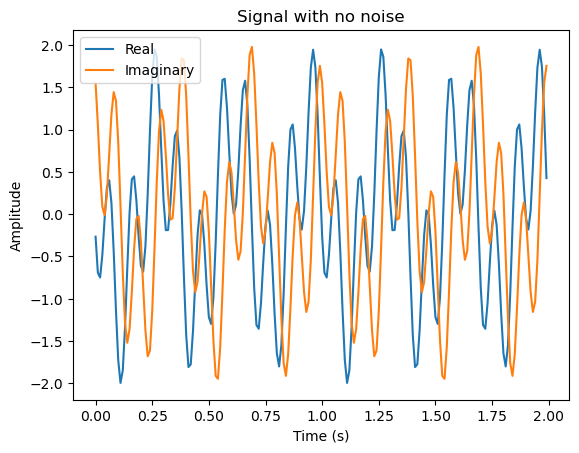

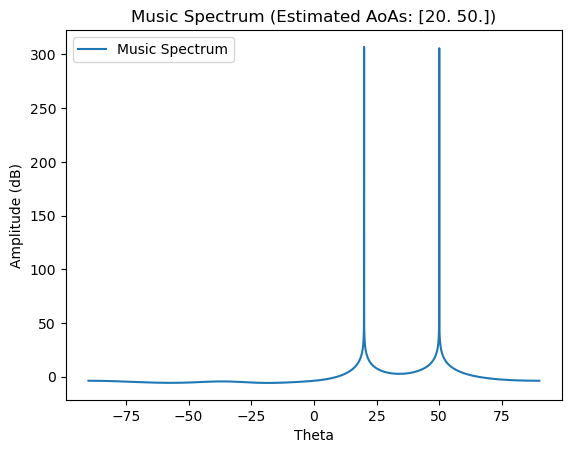

Sensor Covariance Matrix (magnitude):
[[1.00502513e+00 2.14016131e-16]
 [2.16006601e-16 1.00502513e+00]]



A Rs A^H:

 	 Covariance Matrix (magnitude):
[[2.01005025 1.58043185 0.47522577 0.83312522 1.78533991]
 [1.58043185 2.01005025 1.58043185 0.47522577 0.83312522]
 [0.47522577 1.58043185 2.01005025 1.58043185 0.47522577]
 [0.83312522 0.47522577 1.58043185 2.01005025 1.58043185]
 [1.78533991 0.83312522 0.47522577 1.58043185 2.01005025]]
	 Eigen Values:
[5.33021464e+00 4.72003661e+00 4.45201139e-16 2.42979636e-18
 8.91720145e-16]
	 Eigen Vectors:
[[-5.96679156e-01-0.00000000e+00j  1.54285050e-01+0.00000000e+00j
   1.78004777e-02+0.00000000e+00j  4.45278735e-02-0.00000000e+00j
   7.86047403e-01+0.00000000e+00j]
 [ 6.40999420e-02-3.73985537e-01j -8.66792726e-02+5.05722678e-01j
   2.28664079e-01+3.47551936e-02j  5.85636781e-02-6.41674049e-01j
   5.71751387e-02-3.47588581e-01j]
 [ 8.87578942e-17+2.73361260e-16j -6.15328452e-01-2.17314742e-01j
  -1.53005603e-02-6.21573342e-01j -3.59488117

In [70]:
#sample signal frequencies
sample_freqs = [10,3]

#sample signal AoAs
desired_angles = [50,20]

# generate sample signals using sinusoids of given frequencies
s_t = generate_signals(sample_freqs,t_samples,complex=True,verbose=False)

#generate A matrix (with each column as a mode vector) for the given angles
A = generate_mode_vector_matrix(thetas=desired_angles,K_rx=n_antennas,radians=False,verbose=False)

#compute the samples received by each sensor
x_t = np.matmul(A,s_t)

plot_signal(x_t[1,:],t_samples,title="Signal with no noise")

#perform the MUSIC algorithm in transparent mode to understand what is happening
P_mus, thetas, estimated_AoAs = MUSIC(
    x_t=x_t,
    K_rx=n_antennas,
    D_signals=2,
    plot_spectrum=True,
    verbose=True,
    transparent_mode=True,
    s_t=s_t,
    A=A)


## Experiment #2: MUSIC with white noise

Set Noise Covariance Matrix:
[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]



Actual Noise Coveriance Matrix:
[[0.98845674 0.03378153 0.0548053  0.08243931 0.03228502]
 [0.03378153 0.90126645 0.06716751 0.07226898 0.03202026]
 [0.0548053  0.06716751 1.03562192 0.04703914 0.07490607]
 [0.08243931 0.07226898 0.04703914 0.97471927 0.06734457]
 [0.03228502 0.03202026 0.07490607 0.06734457 1.01738597]]


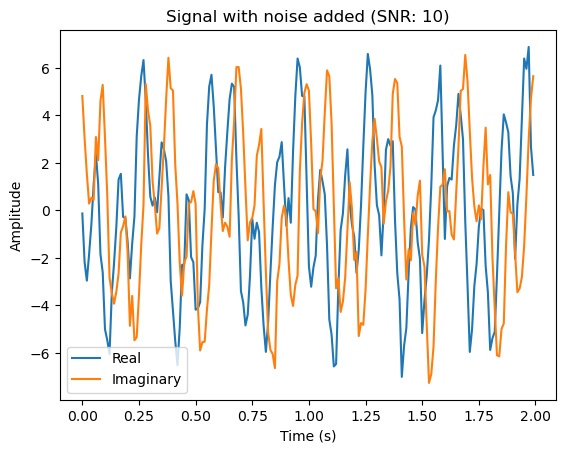

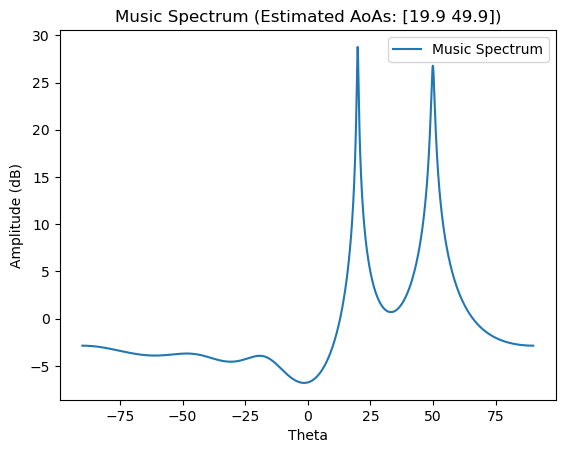

Sensor Covariance Matrix (magnitude):
[[1.00502513e+01 2.20463508e-15]
 [2.08628605e-15 1.00502513e+01]]



A Rs A^H:

 	 Covariance Matrix (magnitude):
[[20.10050251 15.80431855  4.75225773  8.33125215 17.85339914]
 [15.80431855 20.10050251 15.80431855  4.75225773  8.33125215]
 [ 4.75225773 15.80431855 20.10050251 15.80431855  4.75225773]
 [ 8.33125215  4.75225773 15.80431855 20.10050251 15.80431855]
 [17.85339914  8.33125215  4.75225773 15.80431855 20.10050251]]
	 Eigen Values:
[5.33021464e+01 4.72003661e+01 1.48516742e-14 3.82760209e-16
 6.35265025e-15]
	 Eigen Vectors:
[[-5.96679156e-01-0.00000000e+00j  1.54285050e-01+0.00000000e+00j
  -7.74253669e-01+0.00000000e+00j  7.85340699e-02-0.00000000e+00j
   1.20556059e-01+0.00000000e+00j]
 [ 6.40999420e-02-3.73985537e-01j -8.66792726e-02+5.05722678e-01j
  -1.44984867e-01+4.29787586e-01j  7.89894427e-02-1.31689677e-02j
  -5.54414380e-01+2.70612737e-01j]
 [ 7.35904717e-16+4.63666466e-16j -6.15328452e-01-2.17314742e-01j
  -1.10375922e-01-1.

In [71]:
#sample signal frequencies
sample_freqs = [10,3]

#sample signal AoAs
desired_angles = [50,20]

#set noise variance
sigma_2 = 1
cross_corr = 0

#specify SNR
snr_dB = 10

#compute the power and amplitude of the sample signals to achieve the given SNR
P_s_t,Amp_s_t = determine_signal_amplitude(snr_dB,sigma_2)


#compute s_t
s_t = Amp_s_t * generate_signals(sample_freqs,t_samples,complex=True,verbose=False)

#generate A matrix (with each column as a mode vector) for the given angles
A = generate_mode_vector_matrix(thetas=desired_angles,K_rx=n_antennas,radians=False,verbose=False)


#generate noise samples
n_t = generate_noise_samples(sigma_2,cross_corr,n_antennas,len(t_samples),verbose=True)

#compute the samples received by each sensor
x_t = np.matmul(A,s_t) + n_t

plot_signal(x_t[1,:],t_samples,title="Signal with noise added (SNR: {})".format(snr_dB))


#perform the MUSIC algorithm in transparent mode to understand what is happening
P_mus, thetas, estimated_AoAs = MUSIC(
    x_t=x_t,
    K_rx=n_antennas,
    D_signals=2,
    plot_spectrum=True,
    verbose=True,
    transparent_mode=True,
    s_t=s_t,
    A=A)

## Experiment #3: MUSIC with Colored Noise:

### Part 1: Colored Noise with uncorrelated signals

Set Noise Covariance Matrix:
[[1.  0.5 0.5 0.5 0.5]
 [0.5 1.  0.5 0.5 0.5]
 [0.5 0.5 1.  0.5 0.5]
 [0.5 0.5 0.5 1.  0.5]
 [0.5 0.5 0.5 0.5 1. ]]



Actual Noise Coveriance Matrix:
[[1.05386016 0.52503167 0.60073929 0.51981417 0.46516842]
 [0.52503167 0.96687238 0.47715092 0.4741107  0.37841993]
 [0.60073929 0.47715092 1.07260572 0.54538201 0.48995617]
 [0.51981417 0.4741107  0.54538201 0.9707833  0.44829537]
 [0.46516842 0.37841993 0.48995617 0.44829537 0.90554855]]


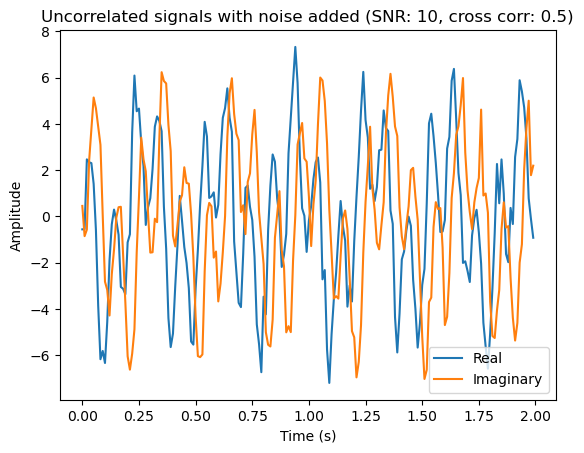

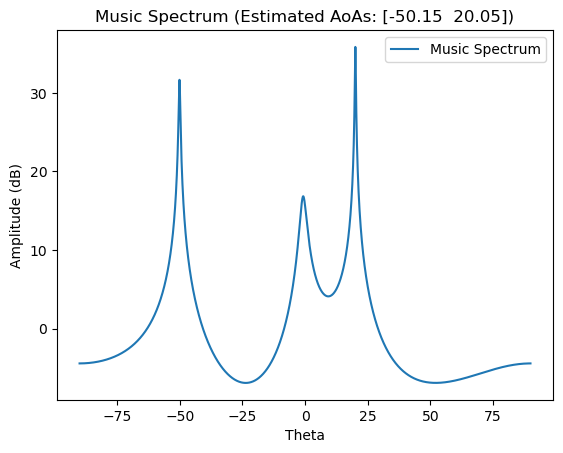

Sensor Covariance Matrix (magnitude):
[[1.00502513e+01 2.20463508e-15]
 [2.08628605e-15 1.00502513e+01]]



A Rs A^H:

 	 Covariance Matrix (magnitude):
[[20.10050251  3.39564703 18.95322585  9.7993143  15.64236211]
 [ 3.39564703 20.10050251  3.39564703 18.95322585  9.7993143 ]
 [18.95322585  3.39564703 20.10050251  3.39564703 18.95322585]
 [ 9.7993143  18.95322585  3.39564703 20.10050251  3.39564703]
 [15.64236211  9.7993143  18.95322585  3.39564703 20.10050251]]
	 Eigen Values:
[5.69906438e+01 4.35118688e+01 1.60775772e-14 8.79970486e-15
 5.33735685e-15]
	 Eigen Vectors:
[[-5.59986940e-01-0.00000000e+00j  2.26338277e-01+0.00000000e+00j
   7.30677801e-01-0.00000000e+00j -2.63762210e-01+0.00000000e+00j
   1.78115296e-01+0.00000000e+00j]
 [-7.88834980e-02+6.19909374e-02j -5.26721741e-01+4.13926554e-01j
   3.64645178e-01+3.63874318e-03j  5.45076783e-01+1.86041802e-01j
  -2.67376913e-01-7.05231949e-02j]
 [ 1.40408935e-01-5.77047328e-01j  4.16649991e-16-9.51280558e-16j
   1.04183538e-01-3.

In [87]:
#sample signal frequencies
sample_freqs = [10,3]

#sample signal AoAs
desired_angles = [-50,20]

#set noise variance
sigma_2 = 1
cross_corr = 0.5

#specify SNR
snr_dB = 10

#compute the power and amplitude of the sample signals to achieve the given SNR
P_s_t,Amp_s_t = determine_signal_amplitude(snr_dB,sigma_2)


#compute s_t
s_t = Amp_s_t * generate_signals(sample_freqs,t_samples,complex=True,verbose=False)

#generate A matrix (with each column as a mode vector) for the given angles
A = generate_mode_vector_matrix(thetas=desired_angles,K_rx=n_antennas,radians=False,verbose=False)


#generate noise samples
n_t = generate_noise_samples(sigma_2,cross_corr,n_antennas,len(t_samples),verbose=True)

#compute the samples received by each sensor
x_t = np.matmul(A,s_t) + n_t

plot_signal(x_t[1,:],t_samples,title="Uncorrelated signals with noise added (SNR: {}, cross corr: {})".format(snr_dB,cross_corr))



#perform the MUSIC algorithm in transparent mode to understand what is happening
P_mus, thetas, estimated_AoAs = MUSIC(
    x_t=x_t,
    K_rx=n_antennas,
    D_signals=2,
    plot_spectrum=True,
    verbose=True,
    transparent_mode=True,
    s_t=s_t,
    A=A)

### Part 2: Colored Noise with Correlated Signals

Set Noise Covariance Matrix:
[[30.   0.1  0.1  0.1  0.1]
 [ 0.1 30.   0.1  0.1  0.1]
 [ 0.1  0.1 30.   0.1  0.1]
 [ 0.1  0.1  0.1 30.   0.1]
 [ 0.1  0.1  0.1  0.1 30. ]]



Actual Noise Coveriance Matrix:
[[31.32697719  1.33164805  1.55213781  1.3538118   1.05193923]
 [ 1.33164805 30.68783447  1.94258372  3.41096502  1.95105446]
 [ 1.55213781  1.94258372 34.7827505   2.69776561  4.66325956]
 [ 1.3538118   3.41096502  2.69776561 28.89137009  1.63281276]
 [ 1.05193923  1.95105446  4.66325956  1.63281276 29.41923759]]


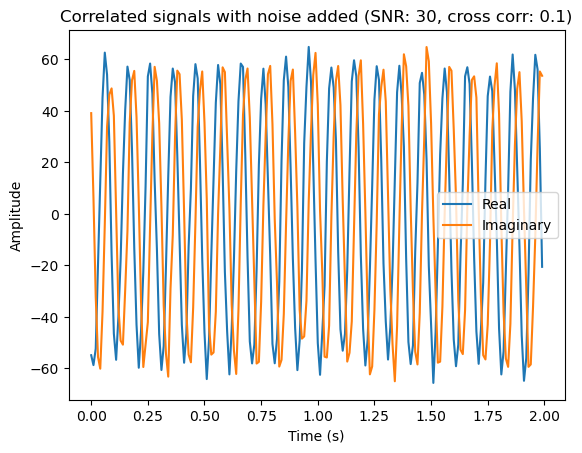

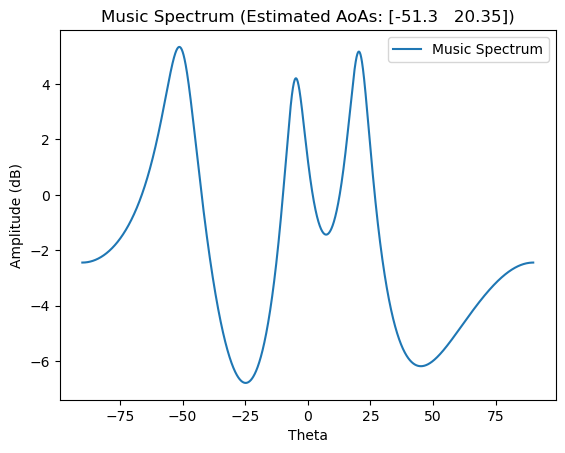

Sensor Covariance Matrix (magnitude):
[[30150.75376884 30150.75376884]
 [30150.75376884 30150.75376884]]



A Rs A^H:

 	 Covariance Matrix (magnitude):
[[120603.01507538  20373.88216366 113719.35509127  58795.88577458
   93854.17265398]
 [ 20373.88216366   3441.82999206  19211.00180546   9932.59121864
   15855.10820791]
 [113719.35509127  19211.00180546 107228.59386468  55439.99217703
   88497.25672417]
 [ 58795.88577458   9932.59121864  55439.99217703  28663.92835915
   45755.40015631]
 [ 93854.17265398  15855.10820791  88497.25672417  45755.40015631
   73038.02246617]]
	 Eigen Values:
[3.32975390e+05 3.71737283e-11 1.37648053e-11 5.30417680e-12
 8.94898584e-12]
	 Eigen Vectors:
[[ 6.01828866e-01+0.j          6.64204002e-01-0.j
   3.95369159e-01+0.j         -1.61509664e-01+0.j
   1.19301787e-01+0.j        ]
 [-7.99387769e-02+0.06282023j  3.49405453e-01-0.19598883j
  -3.28799684e-01+0.17199472j  5.90428197e-01+0.17321402j
   3.46935941e-01+0.43875175j]
 [-1.34165949e-01+0.55139014j  1

In [73]:
#sample signal frequencies
sample_freqs = [10,10]

#sample signal AoAs
desired_angles = [-50,20]

#set noise variance
sigma_2 = 30
cross_corr = 0.1

#specify SNR
snr_dB = 30

#compute the power and amplitude of the sample signals to achieve the given SNR
P_s_t,Amp_s_t = determine_signal_amplitude(snr_dB,sigma_2)


#compute s_t
s_t = Amp_s_t * generate_signals(sample_freqs,t_samples,complex=True,verbose=False)

#generate A matrix (with each column as a mode vector) for the given angles
A = generate_mode_vector_matrix(thetas=desired_angles,K_rx=n_antennas,radians=False,verbose=False)


#generate noise samples
n_t = generate_noise_samples(sigma_2,cross_corr,n_antennas,len(t_samples),verbose=True)

#compute the samples received by each sensor
x_t = np.matmul(A,s_t) + n_t

plot_signal(x_t[1,:],t_samples,title="Correlated signals with noise added (SNR: {}, cross corr: {})".format(snr_dB,cross_corr))



#perform the MUSIC algorithm in transparent mode to understand what is happening
P_mus, thetas, estimated_AoAs = MUSIC(
    x_t=x_t,
    K_rx=n_antennas,
    D_signals=2,
    plot_spectrum=True,
    verbose=True,
    transparent_mode=True,
    s_t=s_t,
    A=A)

## Experiment #4: Characterizing MUSIC Performance over different SNRs and correlations

### Part 1: Comparing the effect of colored noise over SNR

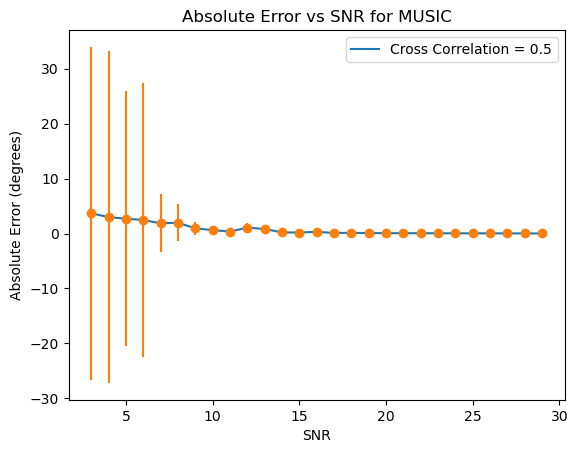

In [79]:
characterize_MUSIC(
        D_signals = 2,
        t_samples = t_samples,
        K_Rx = n_antennas,
        freq_range = [1,10],
        min_freq_diff = 2,
        AoA_range = [-60,60],
        min_angular_diff = 5,
        SNRs = np.arange(3,30,1),
        trials_per_SNR_step = 200,
        sigma_2 = 1,
        cross_corrs = [0.5],
        tail_percentile = 0.95,
        error_bars = True)

### Part 2: Sweeping over various cross correlation coefficients

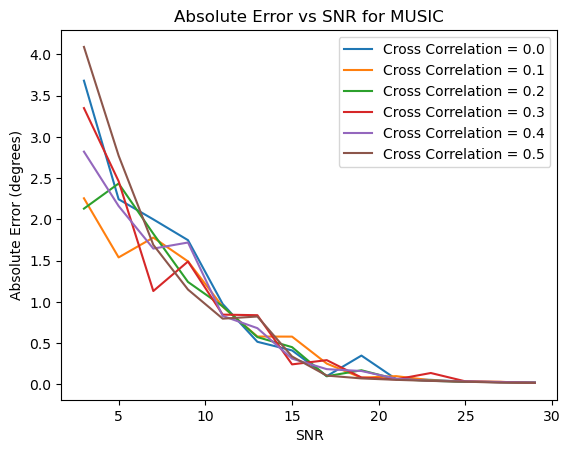

In [81]:
characterize_MUSIC(
        D_signals = 2,
        t_samples = t_samples,
        K_Rx = n_antennas,
        freq_range = [1,10],
        min_freq_diff = 2,
        AoA_range = [-60,60],
        min_angular_diff = 5,
        SNRs = np.arange(3,30,2),
        trials_per_SNR_step = 300,
        sigma_2 = 1,
        cross_corrs = np.arange(0,0.6,0.1),
        tail_percentile = 0.95,
        error_bars = False)